In [3]:
import pandas as pd
from haversine import haversine, Unit
from obspy.taup import TauPyModel
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

# Load stations infos

In [5]:
FILE = 'C:/Users/Romain/PycharmProjects/toolbox/data/recensement_stations_OHASISBIO_RS.csv'
stations = pd.read_csv(FILE )
stations = stations.loc[stations.year==2018]
stations
station_dic = {}
for name in stations.station_name :
    st_lat, st_lon  = stations.loc[stations.station_name==name].lat.values[0],\
    stations.loc[stations.station_name==name].lon.values[0]
    station_dic[name] = [st_lat, st_lon]
    print(name , st_lat, st_lon)

ELAN -56.4602 62.976
MADE -24.2053 63.0102
MADW -29.0473 54.258
NEAMS -31.5758 83.2423
RTJ -24.3792 72.372
SSEIR -33.5175 70.8657
SSWIR -38.5465 52.9287
SWAMS-bot -42.9513 74.5975
WKER2 -46.6015 60.5475


In [101]:
station_dic['SWAMS-bot']

[-42.9513, 74.5975]

# Calculate travel times

In [6]:
# Define station coordinates and initialize model

name = 'SWAMS-bot'
model = TauPyModel(model="ak135")

[st_lat, st_lon]  =  station_dic[name]
def calculate_phases(row):
    """
    Compute travel times and metadata for all phases in `phase_list`.
    Returns a list of dictionaries (one per phase).
    """

    event_lat = row['latitude']
    event_lon = row['longitude']
    event_depth = row['depth']  # Ensure depth is in kilometers
    origin_time = row['time']

    # Calculate angular distance between event and station
    dist_deg = haversine(
        (event_lat, event_lon), (st_lat, st_lon), unit=Unit.DEGREES
    )

    # Get travel times for all phases in the list
    try:
        arrivals = model.get_travel_times(
            source_depth_in_km=event_depth,
            distance_in_degree=dist_deg,
            phase_list=["P", "PKP", "PKiKP", "PKIKP"]
        )
    except ValueError:
        return []  # Return empty list if no arrivals

    phases = []
    for arrival in arrivals:
        phase_info = {
            'phase': arrival.name,
            'travel_time': arrival.time,
            'arrival_time': origin_time + pd.to_timedelta(arrival.time, unit='s'),
            'distance_deg': dist_deg
        }
        phases.append(phase_info)

    return phases

# Load catalogue and compute phases
# PATH = 'C:/Users/Romain/PycharmProjects/NEIC_ISC_join/data/ISC_cat'
PATH = '../../../../data/ISC_cat'
NAME_NEIC = '/NEIC_2018_M6.csv'
catalogue = pd.read_csv(PATH + NAME_NEIC, parse_dates=['time'], date_format='ISO8601')

# Expand DataFrame to include all phases
catalogue['phases'] = catalogue.apply(calculate_phases, axis=1)
catalogue = catalogue.explode('phases').reset_index(drop=True)

# Extract phase details into columns
phase_data = pd.json_normalize(catalogue['phases'])
catalogue = pd.concat([catalogue.drop('phases', axis=1), phase_data], axis=1)

# Drop rows where phases were not found (optional)
catalogue = catalogue.dropna(subset=['phase'])

# Save the extended catalogue
# catalogue.to_csv(PATH + '/NEIC_2018_M6_with_tt.csv', index=False)

In [7]:
catalogue.sort_values("time", inplace=True, ignore_index=True)


In [104]:
catalogue

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,phase,travel_time,arrival_time,distance_deg
0,2018-01-10 02:51:33.290000+00:00,17.4825,-83.5200,19.00,7.5,mww,NaN,12.0,4.581,0.82,...,1.7,0.035,79.0,reviewed,us,us,PKIKP,1181.741049,2018-01-10 03:11:15.031048543+00:00,148.486806
1,2018-01-10 02:51:33.290000+00:00,17.4825,-83.5200,19.00,7.5,mww,NaN,12.0,4.581,0.82,...,1.7,0.035,79.0,reviewed,us,us,PKP,1185.321731,2018-01-10 03:11:18.611730821+00:00,148.486806
2,2018-01-10 02:51:33.290000+00:00,17.4825,-83.5200,19.00,7.5,mww,NaN,12.0,4.581,0.82,...,1.7,0.035,79.0,reviewed,us,us,PKiKP,1186.878295,2018-01-10 03:11:20.168295122+00:00,148.486806
3,2018-01-10 02:51:33.290000+00:00,17.4825,-83.5200,19.00,7.5,mww,NaN,12.0,4.581,0.82,...,1.7,0.035,79.0,reviewed,us,us,PKP,1188.694485,2018-01-10 03:11:21.984484746+00:00,148.486806
4,2018-01-11 18:26:24.240000+00:00,18.3719,96.0717,9.00,6.0,mww,NaN,29.0,2.759,1.01,...,1.8,0.052,35.0,reviewed,us,us,P,636.557333,2018-01-11 18:37:00.797332527+00:00,64.427743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2019-02-14 19:57:04.980000+00:00,35.4267,-36.0378,10.00,6.2,mww,NaN,32.0,8.771,0.80,...,1.8,0.034,83.0,reviewed,us,us,PKiKP,1145.165976,2019-02-14 20:16:10.145975542+00:00,127.240151
317,2019-02-17 14:35:55.840000+00:00,-3.3412,152.1319,368.12,6.4,mww,NaN,23.0,0.845,1.39,...,3.3,0.040,60.0,reviewed,us,us,P,681.851557,2019-02-17 14:47:17.691557280+00:00,78.613076
318,2019-02-17 14:35:55.840000+00:00,-3.3412,152.1319,368.12,6.4,mww,NaN,23.0,0.845,1.39,...,3.3,0.040,60.0,reviewed,us,us,PKiKP,1013.848638,2019-02-17 14:52:49.688638146+00:00,78.613076
319,2019-02-22 10:17:23.770000+00:00,-2.1862,-77.0505,145.00,7.5,mww,NaN,15.0,2.045,1.12,...,1.8,0.026,144.0,reviewed,us,us,PKIKP,1128.845455,2019-02-22 10:36:12.615454716+00:00,128.146472


In [105]:
dat = ['2018-02-25 17:44:44.140000','2018-03-25 20:14:47.690000','2018-03-26 09:51:00.430000','2018-04-02 13:40:34.840000','2018-07-28 22:47:38.740000','2018-08-05 11:46:38.630000','2018-08-19 00:19:40.670000','2018-08-19 14:56:27.490000','2018-09-06 15:49:18.710000','2018-09-10 04:19:02.630000','2018-09-28 10:02:45.250000','2018-10-29 06:54:21.250000','2018-12-05 04:18:08.420000','2018-12-11 02:26:29.420000','2018-12-29 03:39:09.740000']
Err =  [2.66,2.21,2.39,2.01,2.32 ,2.14,1.61,1.78,2.16,1.93,2.03,1.60,1.5,1.88,2.94]
# for i, l in enumerate(dat) :
#     print(catalogue.loc[catalogue['time']==l]['rms'].unique()*2.0)

catalogue.loc[catalogue['time']==dat[6]]

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,phase,travel_time,arrival_time,distance_deg
136,2018-08-19 00:19:40.670000+00:00,-18.1125,-178.153,600.0,8.2,mww,NaN,13.0,3.63,0.79,...,1.9,0.045,47.0,reviewed,us,us,P,715.086402,2018-08-19 00:31:35.756401701+00:00,89.682505
137,2018-08-19 00:19:40.670000+00:00,-18.1125,-178.153,600.0,8.2,mww,NaN,13.0,3.63,0.79,...,1.9,0.045,47.0,reviewed,us,us,PKiKP,1007.660562,2018-08-19 00:36:28.330562214+00:00,89.682505


# Finding candidates

## Filter tools

In [106]:
# Function to downsample audio data
def downsample_audio(data, original_fs, target_fs):
    """Downsample audio data to the target frequency"""
    # print(f"Downsampling from {original_fs}Hz to {target_fs}Hz")
    # Calculate downsampling factor
    factor = int(original_fs / target_fs)
    # Apply anti-aliasing filter before downsampling
    b, a = signal.butter(5, target_fs/2, fs=original_fs, btype='low')
    filtered_data = signal.filtfilt(b, a, data)
    # Downsample by taking every 'factor' sample
    downsampled_data = filtered_data[::factor]
    return downsampled_data, target_fs

# Function to apply dehazing (using spectral subtraction)
def dehaze_audio(data, fs, frame_size=1024, overlap=0.8):
    """Apply spectral subtraction for dehazing"""
    # print("Applying dehazing using spectral subtraction")
    hop_size = int(frame_size * (1 - overlap))
    # Estimate noise profile from first few frames
    num_noise_frames = 5
    noise_estimate = np.zeros(frame_size // 2 + 1)

    frames = []
    for i in range(0, len(data) - frame_size, hop_size):
        frame = data[i:i+frame_size]
        if len(frame) < frame_size:
            frame = np.pad(frame, (0, frame_size - len(frame)))
        frames.append(frame)

    # Estimate noise from first few frames
    for i in range(min(num_noise_frames, len(frames))):
        noise_frame = frames[i]
        noise_spectrum = np.abs(np.fft.rfft(noise_frame * np.hanning(frame_size)))
        noise_estimate += noise_spectrum / num_noise_frames

    # Apply spectral subtraction
    result = np.zeros(len(data))
    window = np.hanning(frame_size)

    for i, frame in enumerate(frames):
        windowed_frame = frame * window
        spectrum = np.fft.rfft(windowed_frame)
        magnitude = np.abs(spectrum)
        phase = np.angle(spectrum)

        # Subtract noise and ensure no negative values
        magnitude = np.maximum(magnitude - noise_estimate * 1.5, 0.01 * magnitude)

        # Reconstruct frame
        enhanced_spectrum = magnitude * np.exp(1j * phase)
        enhanced_frame = np.fft.irfft(enhanced_spectrum)

        # Overlap-add
        start = i * hop_size
        end = start + frame_size
        result[start:end] += enhanced_frame

    # Normalize
    result = result / np.max(np.abs(result))
    return result

# Function to apply Butterworth bandpass filter
def apply_butter_bandpass(data, fs, lowcut, highcut, order=5):
    """Apply Butterworth bandpass filter"""
    # print(f"Applying bandpass filter: {lowcut}-{highcut}Hz, order {order}")
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

# Function to create spectrogram
def create_spectrogram(data, fs, nperseg=256, noverlap=128, cmap='viridis'):
    """Create and return spectrogram of the data"""
    # print("Creating spectrogram")
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return f, t, Sxx

# Function to detect potential seismic events using energy
def detect_seismic_events(data, fs, window_size=5.0, threshold_factor=5.0):
    """Detect potential seismic events based on energy threshold"""
    print("Detecting potential seismic events")
    window_samples = int(window_size * fs)
    energy = []

    # Calculate energy in sliding windows
    for i in range(0, len(data) - window_samples, window_samples // 2):
        window = data[i:i+window_samples]
        window_energy = np.sum(window**2) / len(window)
        energy.append(window_energy)

    # Set threshold as a factor of the median energy
    energy = np.array(energy)
    threshold = np.median(energy) * threshold_factor

    # Find events that exceed threshold
    events = []
    in_event = False
    event_start = 0

    for i, e in enumerate(energy):
        if e > threshold and not in_event:
            in_event = True
            event_start = i * (window_samples // 2) / fs
        elif e <= threshold and in_event:
            in_event = False
            event_end = i * (window_samples // 2) / fs
            events.append((event_start, event_end))

    # Handle if we're still in an event at the end
    if in_event:
        event_end = len(data) / fs
        events.append((event_start, event_end))

    return events, energy, threshold

# Main processing function
def process_underwater_recording(data,df,date_time,original_fs=240., target_fs=50, low_pass=1.5, high_pass=0.6):
    """Process underwater recording to visualize seismic events"""
    # Load data

    print(f"Original sampling rate: {original_fs}Hz")
    print(f"Original data length: {len(data)} samples ({len(data)/original_fs:.2f} seconds)")

    # Downsample to 50Hz
    downsampled_data, new_fs = downsample_audio(data, original_fs, target_fs)
    print(f"Downsampled data length: {len(downsampled_data)} samples ({len(downsampled_data)/new_fs:.2f} seconds)")

    # Apply dehazing
    dehazed_data = dehaze_audio(downsampled_data, new_fs)

    # Apply Butterworth bandpass filter
    filtered_data = apply_butter_bandpass(dehazed_data, new_fs, high_pass, low_pass)

    # Detect potential seismic events
    events, energy, threshold = detect_seismic_events(filtered_data, new_fs)
    time = timedelta(minutes=10)
    for event_start, _ in events:
        if np.abs(time - event_start) < 10 :
            catalogue.loc[catalogue['time'] == date_time,"candidate"] = True
            break
    if True :
        # Create a separate figure for event detection results
        plt.figure(figsize=(10, 4))
        window_size = 5.0  # seconds
        for arrival, phase in zip(df['arrival_time'],df['phase']):
            print(arrival, phase)
            time = arrival - df['arrival_time'].iloc[0] + timedelta(minutes=10)
            time = time.total_seconds()
            plt.axvline(time, color='g', linestyle='--', label=phase)
        time_axis = np.arange(len(energy)) * (window_size/2)
        plt.plot(time_axis, energy)
        plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
        plt.title('Signal Energy for Event Detection')
        plt.xlabel('Time (s)')
        plt.ylabel('Energy')
        plt.legend()
        plt.show()
    return filtered_data, events

## Find candidates

In [107]:
# Configuration
from tqdm.notebook import tqdm
PATH = f"F:/OHASISBIO/2018/{name}"
ORIGINAL_FS = 240.0
TARGET_FS = 60
LOW_PASS = 1.5
HIGH_PASS = 0.6
TIME_TOLERANCE = 10  # seconds

# Initialize candidate column
catalogue['candidate'] = False
catalogue['file_number'] = -1
manager = DatFilesManager(PATH,kwargs='raw')

def find_candidates(manager, catalogue):
    ORIGINAL_FS = 240.0
    TARGET_FS = 60
    LOW_PASS = 1.5
    HIGH_PASS = 0.6
    TIME_TOLERANCE = 10
    # Process each unique event in the catalogue
    for date_time in tqdm(catalogue['time'].unique()):

        event_df = catalogue[catalogue['time'] == date_time]
        first_arrival = event_df['arrival_time'].min()

        # Define time window: 10 minutes before and after first arrival
        start = (first_arrival - timedelta(minutes=10)).replace(tzinfo=None)
        end = (first_arrival + timedelta(minutes=10)).replace(tzinfo=None)

        try:
            # Load and preprocess seismic data
            data = manager.get_segment(start, end)
            file_number = manager.find_file_name(start)
            downsampled_data, new_fs = downsample_audio(data, ORIGINAL_FS, TARGET_FS)
            dehazed_data = dehaze_audio(downsampled_data, new_fs)
            filtered_data = apply_butter_bandpass(dehazed_data, new_fs, HIGH_PASS, LOW_PASS)

            # Detect seismic events (adjust threshold as needed)
            events, energy, threshold = detect_seismic_events(filtered_data, new_fs, threshold_factor=8.0)

            # # Check if any detected event aligns with expected arrival time
            # expected_time_sec = 600  # 10 minutes into the segment
            # for event_start, _ in events:
            #     if abs(event_start - expected_time_sec) < TIME_TOLERANCE:
            #         catalogue.loc[catalogue['time'] == datetime, 'candidate'] = True
            #         break  # Stop checking once a match is found
            event_starts = np.array([e[0] for e in events])
            if np.any(np.abs(event_starts - 600) < TIME_TOLERANCE):
                catalogue.loc[catalogue['time'] == date_time, 'candidate'] = True
                catalogue.loc[catalogue['time'] == date_time, 'file_number'] = file_number

            # Optional: Plot detection results for debugging
            if False:  # Set to True to enable
                plt.figure(figsize=(10, 4))
                time_axis = np.arange(len(energy)) * (5.0 / 2)  # Assuming 5s window
                plt.plot(time_axis, energy)
                plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
                plt.axvline(expected_time_sec, color='g', linestyle='--', label='Expected Arrival')
                plt.xlabel('Time (s)')
                plt.ylabel('Energy')
                plt.legend()
                plt.show()

        except Exception as e:
            print(f"Error processing {date_time}: {str(e)}")
            continue  # Skip to next event on failure
    return data, catalogue

data, catalogue = find_candidates(manager, catalogue)

#first arrival is in the middle
#second arrival plot will be
#dt = sec - first + timedelta(minute=10) and ect.



  0%|          | 0/152 [00:00<?, ?it/s]

Error processing 2018-01-10 02:51:33.290000+00:00: start is before the first file
Error processing 2018-01-11 18:26:24.240000+00:00: start is before the first file
Error processing 2018-01-14 09:18:45.540000+00:00: start is before the first file
Error processing 2018-01-19 16:17:44.720000+00:00: start is before the first file
Error processing 2018-01-21 01:06:42.710000+00:00: start is before the first file
Error processing 2018-01-23 09:31:40.890000+00:00: start is before the first file
Error processing 2018-01-24 10:51:19.090000+00:00: start is before the first file
Error processing 2018-01-25 02:10:34.820000+00:00: start is before the first file
Error processing 2018-01-26 22:47:57.760000+00:00: start is before the first file
Error processing 2018-01-28 16:03:03.970000+00:00: start is before the first file
Error processing 2018-01-31 07:07:00.290000+00:00: start is before the first file
Detecting potential seismic events
Detecting potential seismic events
Detecting potential seismic 

In [108]:
# data.shape

In [109]:
# catalogue['candidate'] = False
# catalogue.loc[catalogue["arrival_time"]>='2018-02-13', ['candidate']] = True
# catalogue.loc[catalogue["arrival_time"]>='2018-07-20', ['candidate']] = False

In [110]:
# plt.figure()
# time = np.arange(len(data))/240.
# plt.plot(time, data)
# df = catalogue[catalogue['time'] == datetime]
# for arrivals in df['arrival_time']:
#     time = arrivals - df['arrival_time'].iloc[0] + timedelta(minutes=10)
#     time = time.total_seconds()
#     plt.axvline(time, color='r', linestyle='--', label='Arrivals')

In [111]:
catalogue[catalogue["candidate"]==True]['time'].unique()

<DatetimeArray>
['2018-02-06 15:50:43.320000+00:00', '2018-03-06 14:13:07.650000+00:00',
 '2018-03-08 17:39:51.100000+00:00', '2018-03-24 11:23:32.050000+00:00',
 '2018-03-25 20:14:47.690000+00:00', '2018-03-26 09:51:00.430000+00:00',
 '2018-03-29 21:25:36.790000+00:00', '2018-04-02 13:40:34.840000+00:00',
        '2018-04-19 21:09:17+00:00', '2018-06-21 21:13:32.660000+00:00',
 '2018-07-17 07:02:53.020000+00:00', '2018-07-28 17:07:23.380000+00:00',
 '2018-07-28 22:47:38.740000+00:00', '2018-08-10 18:12:07.020000+00:00',
 '2018-08-15 21:56:56.310000+00:00', '2018-08-17 23:22:24.950000+00:00',
 '2018-08-19 14:56:27.490000+00:00', '2018-08-22 09:31:45.530000+00:00',
 '2018-08-29 03:51:56.100000+00:00', '2018-09-06 15:49:18.710000+00:00',
 '2018-09-08 07:16:49.620000+00:00', '2018-09-18 07:27:41.320000+00:00',
 '2018-09-28 10:02:45.250000+00:00', '2018-10-10 22:00:34.500000+00:00',
 '2018-10-16 01:03:43.580000+00:00', '2018-10-25 22:54:52.630000+00:00',
 '2018-10-30 02:13:39.480000+00:00'

In [112]:
catalogue.to_csv(f'../../../../data/{name}_2018_M.csv',index=False)

In [113]:
catalogue[catalogue['candidate'] == True]['file_number'].unique()

array([  22,  125,  133,  192,  197,  199,  212,  225,  289,  523,  617,
        660,  661,  708,  727,  735,  741,  751,  776,  808,  814,  851,
        888,  935,  954,  991, 1006, 1025, 1068, 1105, 1123, 1140, 1162,
       1181, 1191, 1197, 1211, 1229, 1236, 1301, 1320], dtype=int64)

# *ISC ERROR Scrapping*


In [10]:
import requests
import xml.etree.ElementTree as ET
import csv
from datetime import datetime

# List of event timestamps
timestamps = [
    "2018-02-25 17:44:44.140000",
    "2018-03-25 20:14:47.690000",
    "2018-03-26 09:51:00.430000",
    "2018-04-02 13:40:34.840000",
    "2018-07-28 22:47:38.740000",
    "2018-08-05 11:46:38.630000",
    "2018-08-19 00:19:40.670000",
    "2018-08-19 14:56:27.490000",
    "2018-09-06 15:49:18.710000",
    "2018-09-10 04:19:02.630000",
    "2018-09-28 10:02:45.250000",
    "2018-10-29 06:54:21.250000",
    "2018-12-05 04:18:08.420000",
    "2018-12-11 02:26:29.420000",
    "2018-12-29 03:39:09.740000",
]

# Base URL for ISC QuakeML queries
BASE_URL = "https://www.isc.ac.uk/cgi-bin/web-db-run"

# Function to query ISC and get uncertainty
def get_uncertainty(event_time):
    # Convert event time to ISC format
    dt = datetime.strptime(event_time, "%Y-%m-%d %H:%M:%S.%f")
    search_time = dt.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-4]  # Keep only the first two digits of milliseconds

    # Construct API request URL
    params = {
        "request": "COMPREHENSIVE",
        "out_format": "QuakeML",
        "start_year": dt.year,
        "start_month": dt.month,
        "start_day": dt.day,
        "start_time": (dt- timedelta(seconds=60)).strftime("%H:%M:%S"),
        "end_year": dt.year,
        "end_month": dt.month,
        "end_day": dt.day,
        "end_time": (dt+ timedelta(seconds=60)).strftime("%H:%M:%S"),
    }

    response = requests.get(BASE_URL, params=params)

    # Check if the response is successful
    if response.status_code != 200:
        print(f"Request failed for {event_time} with status code {response.status_code}")
        return None  # Return None if request failed

    # Check if the response body is empty
    if not response.text.strip():
        print(f"Empty response for {event_time}")
        return None  # Return None if no content in the response

    try:
        # Parse XML response
        root = ET.fromstring(response.text)
    except ET.ParseError as e:
        print(f"XML parsing error for {event_time}: {e}")
        return None  # Return None if XML parsing fails

    # Find the exact matching event
    for origin in root.findall(".//{*}origin"):
        time_elem = origin.find("{*}time/{*}value")
        uncertainty_elem = origin.find("{*}time/{*}uncertainty")
        depth_elem = origin.find("{*}depth/{*}value")

        if time_elem is not None and uncertainty_elem is not None:
            event_time_utc = time_elem.text
            event_time_utc = event_time_utc.replace("Z", "")  # Remove 'Z' for direct comparison

            # Match the timestamp to milliseconds (only first two digits of milliseconds)
            event_time_utc_ms = event_time_utc[:23]  # First two digits of milliseconds
            search_time_ms = search_time[:23]  # First two digits of milliseconds

            # Debug print: show the event time comparison for debugging
            print(f"Checking: Requested Time: {search_time_ms} vs Event Time: {event_time_utc_ms}")

            # Compare timestamps with only first two digits of milliseconds
            if event_time_utc_ms == search_time_ms:  # Compare only up to two digits of milliseconds
                uncertainty = uncertainty_elem.text
                depth = depth_elem.text
                return event_time_utc, uncertainty, depth

    return None
if True :
    # Store results
    results = []

    # Loop through each timestamp and get uncertainty
    for timestamp in key_times:
        data = get_uncertainty(timestamp)
        if data:
            event_time, uncertainty, depth = data
            depth = float(depth)*1e-3 #converting to Km
            results.append([timestamp, event_time, uncertainty, depth])
            print(f"Event: {timestamp} -> Uncertainty: {uncertainty} | Depth: {depth} km")
        else:
            results.append([timestamp, "Not Found", "N/A"])
            print(f"Event: {timestamp} -> No data found")

    # Save results to CSV
    csv_filename = f"../../../../data/seismic_uncertainty_results_{name}.csv"
    with open(csv_filename, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Requested Time", "Event Time (UTC)", "Uncertainty", "Depth"])
        writer.writerows(results)

    print(f"\nResults saved to {csv_filename}")


Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:13.46
Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:30.33
Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:29.92
Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:30.30
Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:31.50
Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:31.70
Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:31.88
Checking: Requested Time: 2018-01-10T02:51:33.29 vs Event Time: 2018-01-10T02:51:33.29
Event: 2018-01-10 02:51:33.290000 -> Uncertainty: 1.65 | Depth: 19.0 km
Checking: Requested Time: 2018-01-11T18:26:24.24 vs Event Time: 2018-01-11T18:25:56.80
Checking: Requested Time: 2018-01-11T18:26:24.24 vs Event Time: 2018-01-11T18:26:16.60
Checking: Requested Time: 2018-01-11T18:26:24.24 vs Event 

# Compare ISC / NEIC

### NEIC

In [8]:
catalogue['key_time'] = catalogue['time'].copy()

catalogue
key_times =pd.unique( catalogue['key_time'].dt.strftime("%Y-%m-%d %H:%M:%S.%f").values)

In [9]:
key_times = key_times.tolist()

### ISC GEM

In [117]:
PATH = '../../../../data/ISC_cat'
NAME_NEIC = '/GEM_merged_M6.csv'
catalogue_gem = pd.read_csv(PATH + NAME_NEIC, parse_dates=['time', 'key_time'], date_format='ISO8601')

# Expand DataFrame to include all phases
catalogue_gem['phases'] = catalogue_gem.apply(calculate_phases, axis=1)
catalogue_gem = catalogue_gem.explode('phases').reset_index(drop=True)

# Extract phase details into columns
phase_data = pd.json_normalize(catalogue_gem['phases'])
catalogue_gem = pd.concat([catalogue_gem.drop('phases', axis=1), phase_data], axis=1)

# Drop rows where phases were not found (optional)
catalogue_gem = catalogue_gem.dropna(subset=['phase'])
catalogue_gem

,time,latitude,longitude,depth,mag,smajax,sminax,strike,depthError,event_id,key_time,place,phase,travel_time,arrival_time,distance_deg
0,2018-01-10 02:51:30.760000+00:00,17.366,-83.488,5.0,7.52,4.0,3.1,81.6,4.5,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKIKP,1183.957630,2018-01-10 03:11:14.717630065+00:00,148.371477
1,2018-01-10 02:51:30.760000+00:00,17.366,-83.488,5.0,7.52,4.0,3.1,81.6,4.5,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKP,1187.413662,2018-01-10 03:11:18.173661594+00:00,148.371477
2,2018-01-10 02:51:30.760000+00:00,17.366,-83.488,5.0,7.52,4.0,3.1,81.6,4.5,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKiKP,1189.040421,2018-01-10 03:11:19.800420759+00:00,148.371477
3,2018-01-10 02:51:30.760000+00:00,17.366,-83.488,5.0,7.52,4.0,3.1,81.6,4.5,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKP,1190.590077,2018-01-10 03:11:21.350076870+00:00,148.371477
4,2018-01-11 18:26:24.250000+00:00,18.342,95.992,12.1,5.93,3.7,3.6,148.0,3.9,617446172,2018-01-11 18:26:24.240000+00:00,"40 km WSW of Pyu, Myanmar",P,635.721219,2018-01-11 18:36:59.971219305+00:00,64.376754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2019-02-14 19:57:05.650000+00:00,35.283,-36.170,11.9,6.16,5.7,4.1,142.1,3.6,614774103,2019-02-14 19:57:04.980000+00:00,northern Mid-Atlantic Ridge,PKiKP,1144.879013,2019-02-14 20:16:10.529012527+00:00,127.259597
317,2019-02-17 14:35:56.150000+00:00,-3.439,152.171,376.4,6.38,3.9,3.0,54.4,6.2,615221632,2019-02-17 14:35:55.840000+00:00,"95 km N of Rabaul, Papua New Guinea",P,680.816364,2019-02-17 14:47:16.966364403+00:00,78.574604
318,2019-02-17 14:35:56.150000+00:00,-3.439,152.171,376.4,6.38,3.9,3.0,54.4,6.2,615221632,2019-02-17 14:35:55.840000+00:00,"95 km N of Rabaul, Papua New Guinea",PKiKP,1012.866358,2019-02-17 14:52:49.016358483+00:00,78.574604
319,2019-02-22 10:17:23.040000+00:00,-2.251,-77.000,152.4,7.48,3.3,2.9,74.6,5.4,614969911,2019-02-22 10:17:23.770000+00:00,"115 km ESE of Palora, Ecuador",PKIKP,1127.791300,2019-02-22 10:36:10.831300229+00:00,128.066039


### ISC EBH

In [118]:
PATH = '../../../../data/ISC_cat'
NAME_NEIC = '/EHB_merged_M6.csv'
catalogue_ebh = pd.read_csv(PATH + NAME_NEIC, parse_dates=['time', 'key_time'], date_format='ISO8601')

# Expand DataFrame to include all phases
catalogue_ebh['phases'] = catalogue_ebh.apply(calculate_phases, axis=1)
catalogue_ebh = catalogue_ebh.explode('phases').reset_index(drop=True)

# Extract phase details into columns
phase_data = pd.json_normalize(catalogue_ebh['phases'])
catalogue_ebh = pd.concat([catalogue_ebh.drop('phases', axis=1), phase_data], axis=1)

# Drop rows where phases were not found (optional)
catalogue_ebh = catalogue_ebh.dropna(subset=['phase'])
catalogue_ebh

,time,latitude,longitude,depth,mag,timeError,horizontalError,depthError,event_id,key_time,place,phase,travel_time,arrival_time,distance_deg
0,2018-01-10 02:51:30.769999+00:00,17.390,-83.489,5.0,7.5,0.92,1.26,0.00,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKIKP,1183.991935,2018-01-10 03:11:14.761934443+00:00,148.392458
1,2018-01-10 02:51:30.769999+00:00,17.390,-83.489,5.0,7.5,0.92,1.26,0.00,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKP,1187.468282,2018-01-10 03:11:18.238280835+00:00,148.392458
2,2018-01-10 02:51:30.769999+00:00,17.390,-83.489,5.0,7.5,0.92,1.26,0.00,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKiKP,1189.083653,2018-01-10 03:11:19.853651970+00:00,148.392458
3,2018-01-10 02:51:30.769999+00:00,17.390,-83.489,5.0,7.5,0.92,1.26,0.00,611634051,2018-01-10 02:51:33.290000+00:00,"203 km NNE of Barra Patuca, Honduras",PKP,1190.674454,2018-01-10 03:11:21.444453029+00:00,148.392458
4,2018-01-11 18:26:24.339999+00:00,18.390,95.987,12.1,5.9,0.99,2.03,0.91,617446172,2018-01-11 18:26:24.240000+00:00,"40 km WSW of Pyu, Myanmar",P,636.012234,2018-01-11 18:37:00.352232914+00:00,64.421197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2019-02-14 19:57:05.710000+00:00,35.338,-36.173,11.9,6.2,1.15,2.89,1.77,614774103,2019-02-14 19:57:04.980000+00:00,northern Mid-Atlantic Ridge,PKiKP,1144.939264,2019-02-14 20:16:10.649263676+00:00,127.289765
317,2019-02-17 14:35:56.500000+00:00,-3.453,152.154,376.4,6.4,0.95,1.81,0.79,615221632,2019-02-17 14:35:55.840000+00:00,"95 km N of Rabaul, Papua New Guinea",P,680.697780,2019-02-17 14:47:17.197779559+00:00,78.552649
318,2019-02-17 14:35:56.500000+00:00,-3.453,152.154,376.4,6.4,0.95,1.81,0.79,615221632,2019-02-17 14:35:55.840000+00:00,"95 km N of Rabaul, Papua New Guinea",PKiKP,1012.832650,2019-02-17 14:52:49.332650054+00:00,78.552649
319,2019-02-22 10:17:23.250000+00:00,-2.200,-76.988,152.4,7.5,0.93,1.63,0.54,614969911,2019-02-22 10:17:23.770000+00:00,"115 km ESE of Palora, Ecuador",PKIKP,1127.868319,2019-02-22 10:36:11.118318602+00:00,128.106471


# Comparaison

## Merge catalogues

In [119]:
import pandas as pd

# Example: assume your three dataframes are named catalogue_ebh, catalogue, and catalogue_gem

# Optionally, if you want to compare only one phase (e.g., only phase "P"):
# catalogue_ebh = catalogue_ebh[catalogue_ebh['phase'] == 'P']
# catalogue = catalogue[catalogue['phase'] == 'P']
# catalogue_gem = catalogue_gem[catalogue_gem['phase'] == 'P']



# Rename columns for clarity
df_ebh = catalogue_ebh.rename(columns={
    'time': 'time_ebh',
    'travel_time': 'travel_time_ebh',
    'distance_deg': 'distance_deg_ebh',
    'arrival_time': 'arrival_time_ebh'
})
df_neic = catalogue.rename(columns={
    'time': 'time_neic',
    'travel_time': 'travel_time_neic',
    'distance_deg': 'distance_deg_neic',
    'arrival_time': 'arrival_time_neic'
})
df_gem = catalogue_gem.rename(columns={
    'time': 'time_gem',
    'travel_time': 'travel_time_gem',
    'distance_deg': 'distance_deg_gem',
    'arrival_time': 'arrival_time_gem'
})


# Function to group and select the earliest phase arrival
def select_earliest(df, time_col):
    """Sort by arrival time, then travel time as a fallback, and keep first."""
    return df.sort_values(by=[time_col], ascending=[True]).groupby(['key_time', 'phase'], as_index=False).first()

# Apply the function to each catalogue
df_ebh_grouped = select_earliest(df_ebh, 'arrival_time_ebh')
df_neic_grouped = select_earliest(df_neic, 'arrival_time_neic')
df_gem_grouped = select_earliest(df_gem, 'arrival_time_gem')

# Merge using outer join to keep all phases
merged = (
    df_ebh_grouped.merge(df_neic_grouped, on=['key_time', 'phase'], how='outer', suffixes=('_ebh', '_neic'))
                  .merge(df_gem_grouped, on=['key_time', 'phase'], how='outer', suffixes=('', '_gem'))
)

# Inspect the merged DataFrame
print(merged.head())


# Convert time columns to datetime (if not already in datetime format)
merged['time_ebh'] = pd.to_datetime(merged['time_ebh'])
merged['time_neic'] = pd.to_datetime(merged['time_neic'])
merged['time_gem'] = pd.to_datetime(merged['time_gem'])

merged['arrival_time_ebh'] =  pd.to_datetime(merged['arrival_time_ebh'])
merged['arrival_time_neic'] = pd.to_datetime(merged['arrival_time_neic'])
merged['arrival_time_gem'] =  pd.to_datetime(merged['arrival_time_gem'])

# Calculate time differences in seconds between the catalogues
merged['time_diff_neic_ebh'] = (merged['time_neic'] - merged['time_ebh']).dt.total_seconds()
merged['time_diff_ebh_gem'] = (merged['time_ebh'] - merged['time_gem']).dt.total_seconds()
merged['time_diff_neic_gem'] = (merged['time_neic'] - merged['time_gem']).dt.total_seconds()

# Calculate time differences in seconds between the catalogues
merged['arrival_time_diff_neic_ebh'] =(merged['arrival_time_neic'] - merged['arrival_time_ebh']).dt.total_seconds()
merged['arrival_time_diff_ebh_gem'] = (merged['arrival_time_ebh'] - merged['arrival_time_gem']).dt.total_seconds()
merged['arrival_time_diff_neic_gem'] =(merged['arrival_time_neic'] - merged['arrival_time_gem']).dt.total_seconds()

# Calculate differences in travel time (assuming numeric values)
merged['travel_time_diff_neic_ebh'] = merged['travel_time_neic'] - merged['travel_time_ebh']
merged['travel_time_diff_ebh_gem'] = merged['travel_time_ebh'] - merged['travel_time_gem']
merged['travel_time_diff_neic_gem'] = merged['travel_time_neic'] - merged['travel_time_gem']

# Calculate differences in distance (distance_deg)
merged['distance_diff_neic_ebh'] = merged['distance_deg_neic'] - merged['distance_deg_ebh']
merged['distance_diff_ebh_gem'] = merged['distance_deg_ebh'] - merged['distance_deg_gem']
merged['distance_diff_neic_gem'] = merged['distance_deg_neic'] - merged['distance_deg_gem']

# Inspect the merged result
merged.columns

                          key_time  phase                         time_ebh  \
0 2018-01-10 02:51:33.290000+00:00  PKIKP 2018-01-10 02:51:30.769999+00:00   
1 2018-01-10 02:51:33.290000+00:00    PKP 2018-01-10 02:51:30.769999+00:00   
2 2018-01-10 02:51:33.290000+00:00  PKiKP 2018-01-10 02:51:30.769999+00:00   
3 2018-01-11 18:26:24.240000+00:00      P 2018-01-11 18:26:24.339999+00:00   
4 2018-01-11 18:26:24.240000+00:00  PKiKP 2018-01-11 18:26:24.339999+00:00   

   latitude_ebh  longitude_ebh  depth_ebh  mag_ebh  timeError  \
0         17.39        -83.489        5.0      7.5       0.92   
1         17.39        -83.489        5.0      7.5       0.92   
2         17.39        -83.489        5.0      7.5       0.92   
3         18.39         95.987       12.1      5.9       0.99   
4         18.39         95.987       12.1      5.9       0.99   

   horizontalError_ebh  depthError_ebh  ...   mag smajax  sminax strike  \
0                 1.26            0.00  ...  7.52    4.0     3.1 

Index(['key_time', 'phase', 'time_ebh', 'latitude_ebh', 'longitude_ebh',
       'depth_ebh', 'mag_ebh', 'timeError', 'horizontalError_ebh',
       'depthError_ebh', 'event_id', 'place_ebh', 'travel_time_ebh',
       'arrival_time_ebh', 'distance_deg_ebh', 'time_neic', 'latitude_neic',
       'longitude_neic', 'depth_neic', 'mag_neic', 'magType', 'nst', 'gap',
       'dmin', 'rms', 'net', 'id', 'updated', 'place_neic', 'type',
       'horizontalError_neic', 'depthError_neic', 'magError', 'magNst',
       'status', 'locationSource', 'magSource', 'travel_time_neic',
       'arrival_time_neic', 'distance_deg_neic', 'candidate', 'file_number',
       'time_gem', 'latitude', 'longitude', 'depth', 'mag', 'smajax', 'sminax',
       'strike', 'depthError', 'event_id_gem', 'place', 'travel_time_gem',
       'arrival_time_gem', 'distance_deg_gem', 'time_diff_neic_ebh',
       'time_diff_ebh_gem', 'time_diff_neic_gem', 'arrival_time_diff_neic_ebh',
       'arrival_time_diff_ebh_gem', 'arrival_time

### export corection file as catalogue_cor_{name}.csv

In [120]:
times = [
'2018-02-25 17:44:44.14',
'2018-03-25 20:14:47.69',
'2018-03-26 09:51:00.43',
'2018-04-02 13:40:34.84',
'2018-07-28 22:47:38.74',
'2018-08-05 11:46:38.63',
'2018-08-19 00:19:40.67',
'2018-08-19 14:56:27.49',
'2018-09-06 15:49:18.71',
'2018-09-10 04:19:02.63',
'2018-09-28 10:02:45.25',
'2018-10-29 06:54:21.25',
'2018-12-05 04:18:08.42',
'2018-12-11 02:26:29.42',
'2018-12-29 03:39:09.74']
#
# times = pd.to_datetime(times, utc=True)
# merged[merged['key_time'].isin(times)]['arrival_time_diff_neic_gem']
merged[['key_time','phase','arrival_time_diff_neic_gem', 'arrival_time_diff_neic_ebh','timeError']].to_csv(f'../../../../data/catalogue_cor_{name}.csv',index=False)

## Plots

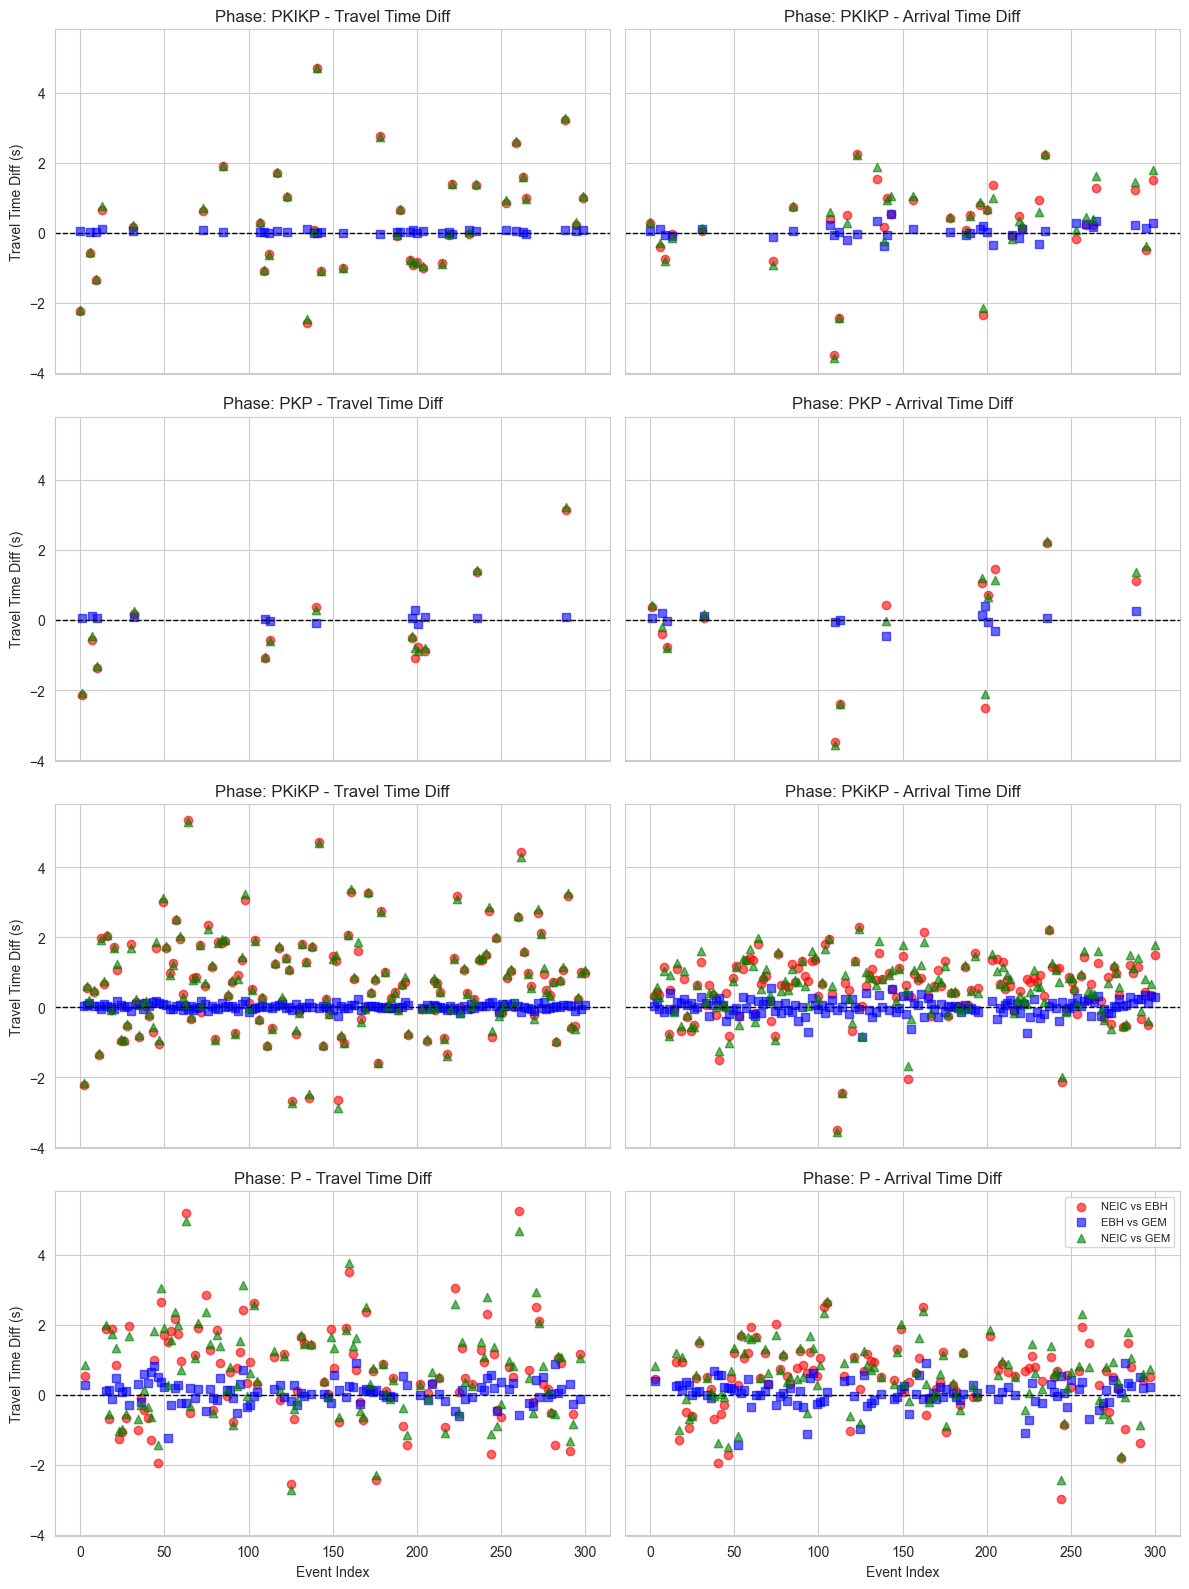

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure style
sns.set_style("whitegrid")

# Get unique phases
phases = merged['phase'].unique()

# Create subplots (rows = number of phases, 2 columns: Travel Time | Arrival Time)
fig, axes = plt.subplots(len(phases), 2, figsize=(12, 4 * len(phases)), sharex=True, sharey=True)

# Loop through each phase and plot in subplots
for i, phase in enumerate(phases):
    subset = merged[merged['phase'] == phase]

    # Travel Time Differences (Left Column)
    axes[i, 0].scatter(subset.index, subset['travel_time_diff_neic_ebh'], marker='o', color='r', label='NEIC vs GEM', alpha=0.6)
    axes[i, 0].scatter(subset.index, subset['travel_time_diff_ebh_gem'], marker='s', color='b', label='EBH vs GEM', alpha=0.6)
    axes[i, 0].scatter(subset.index, subset['travel_time_diff_neic_gem'], marker='^', color='g', label='NEIC vs GEM', alpha=0.6)
    axes[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i, 0].set_title(f"Phase: {phase} - Travel Time Diff")
    axes[i, 0].set_ylabel("Travel Time Diff (s)")
    if i == len(phases) - 1:
        axes[i, 0].set_xlabel("Event Index")

    # Arrival Time Differences (Right Column)
    axes[i, 1].scatter(subset.index, subset['arrival_time_diff_neic_ebh'], marker='o', color='r', label='NEIC vs EBH', alpha=0.6)
    axes[i, 1].scatter(subset.index, subset['arrival_time_diff_ebh_gem'], marker='s', color='b', label='EBH vs GEM', alpha=0.6)
    axes[i, 1].scatter(subset.index, subset['arrival_time_diff_neic_gem'], marker='^', color='g', label='NEIC vs GEM', alpha=0.6)
    axes[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i, 1].set_title(f"Phase: {phase} - Arrival Time Diff")
    if i == len(phases) - 1:
        axes[i, 1].set_xlabel("Event Index")

# Adjust layout and add legend
plt.tight_layout()
plt.legend(loc='upper right', fontsize=8)
plt.show()


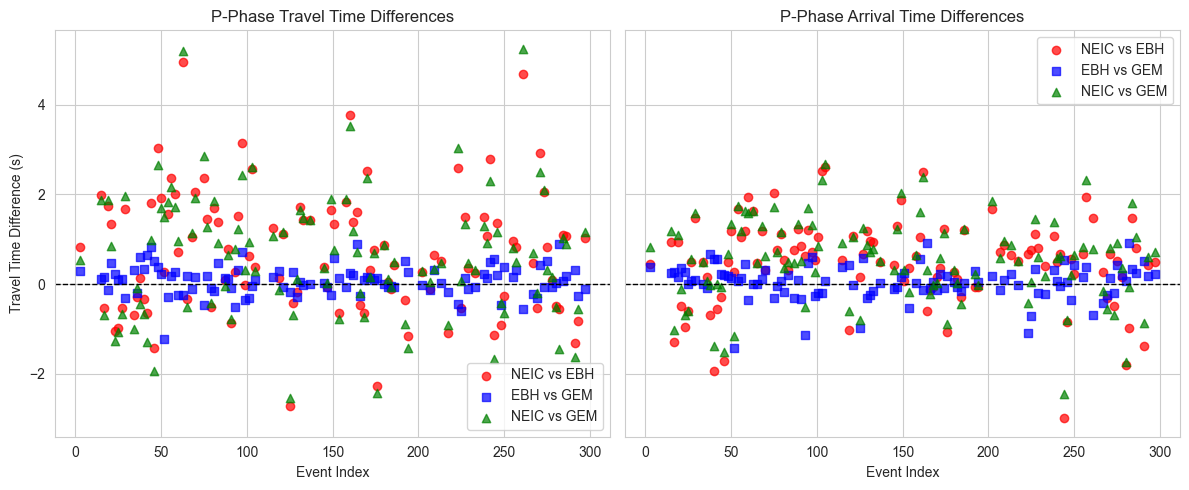

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure style
sns.set_style("whitegrid")

# Filter data for P-phase
p_phase_merged = merged[merged['phase'] == 'P']

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

### Travel Time Differences (Left)
axes[0].scatter(p_phase_merged.index, p_phase_merged['travel_time_diff_neic_gem'], marker='o', color='r', alpha=0.7, label='NEIC vs EBH')
axes[0].scatter(p_phase_merged.index, p_phase_merged['travel_time_diff_ebh_gem'], marker='s', color='b', alpha=0.7, label='EBH vs GEM')
axes[0].scatter(p_phase_merged.index, p_phase_merged['travel_time_diff_neic_ebh'], marker='^', color='g', alpha=0.7, label='NEIC vs GEM')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_title("P-Phase Travel Time Differences")
axes[0].set_xlabel("Event Index")
axes[0].set_ylabel("Travel Time Difference (s)")
axes[0].legend()

### Arrival Time Differences (Right)
axes[1].scatter(p_phase_merged.index, p_phase_merged['arrival_time_diff_neic_ebh'], marker='o', color='r', alpha=0.7, label='NEIC vs EBH')
axes[1].scatter(p_phase_merged.index, p_phase_merged['arrival_time_diff_ebh_gem'], marker='s', color='b', alpha=0.7, label='EBH vs GEM')
axes[1].scatter(p_phase_merged.index, p_phase_merged['arrival_time_diff_neic_gem'], marker='^', color='g', alpha=0.7, label='NEIC vs GEM')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title("P-Phase Arrival Time Differences")
axes[1].set_xlabel("Event Index")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## On sigle phase

In [123]:
import pandas as pd
import os
from datetime import datetime

# Rename columns for clarity
df_ebh = catalogue_ebh.rename(columns={
    'time': 'time_ebh',
    'travel_time': 'travel_time_ebh',
    'distance_deg': 'distance_deg_ebh',
    'arrival_time': 'arrival_time_ebh'
})
df_neic = catalogue.rename(columns={
    'time': 'time_neic',
    'travel_time': 'travel_time_neic',
    'distance_deg': 'distance_deg_neic',
    'arrival_time': 'arrival_time_neic'
})
df_gem = catalogue_gem.rename(columns={
    'time': 'time_gem',
    'travel_time': 'travel_time_gem',
    'distance_deg': 'distance_deg_gem',
    'arrival_time': 'arrival_time_gem'
})


import pandas as pd
import os

# --- Step 1: Filter each catalogue to only include P-phase events ---
phase = 'P'
# For GEM catalogue:
catalogue_gem_p = df_gem[df_gem['phase'] == phase].copy()
# Sort by GEM arrival time (assuming the column is named 'arrival_time_gem')
catalogue_gem_p = catalogue_gem_p.sort_values(by='arrival_time_gem')
# For events with multiple P arrivals, keep the earliest arrival
catalogue_gem_p = catalogue_gem_p.drop_duplicates(subset='event_id', keep='first')

# For NEIC catalogue:
catalogue_neic_p = df_neic[df_neic['phase'] == phase].copy()
# Sort by NEIC arrival time (assuming the column 'time' represents arrival time)
catalogue_neic_p = catalogue_neic_p.sort_values(by='arrival_time_neic')
catalogue_neic_p = catalogue_neic_p.drop_duplicates(subset='key_time', keep='first')

# For EBH catalogue:
catalogue_ebh_p = df_ebh[df_ebh['phase'] == phase].copy()
# Sort by EBH arrival time (assuming 'time' is the arrival time here)
catalogue_ebh_p = catalogue_ebh_p.sort_values(by='arrival_time_ebh')
catalogue_ebh_p = catalogue_ebh_p.drop_duplicates(subset='event_id', keep='first')

# --- Step 2: Merge NEIC and GEM catalogues ---
# First, merge the filtered NEIC and GEM on 'key_time'
merged_neic_gem = pd.merge(
    catalogue_neic_p,
    catalogue_gem_p,
    on='key_time',
    how='left',
    suffixes=('_neic', '_gem')
)

# --- Step 3: Merge with EBH catalogue ---
# Then, merge the result with the filtered EBH catalogue on 'event_id'
final_merged = pd.merge(
    merged_neic_gem,
    catalogue_ebh_p,
    on='event_id',
    how='left',
    suffixes=('', '_ebh')
)



In [124]:
# Convert time columns to datetime (if not already in datetime format)
final_merged['time_ebh'] = pd.to_datetime(final_merged['time_ebh'])
final_merged['time_neic'] = pd.to_datetime(final_merged['time_neic'])
final_merged['time_gem'] = pd.to_datetime(final_merged['time_gem'])

final_merged['arrival_time_ebh'] =  pd.to_datetime(final_merged['arrival_time_ebh'])
final_merged['arrival_time_neic'] = pd.to_datetime(final_merged['arrival_time_neic'])
final_merged['arrival_time_gem'] =  pd.to_datetime(final_merged['arrival_time_gem'])

# Calculate time differences in seconds between the catalogues
final_merged['time_diff_neic_ebh'] = (final_merged['time_neic'] - final_merged['time_ebh']).dt.total_seconds()
final_merged['time_diff_ebh_gem'] = (final_merged['time_ebh'] - final_merged['time_gem']).dt.total_seconds()
final_merged['time_diff_neic_gem'] = (final_merged['time_neic'] - final_merged['time_gem']).dt.total_seconds()

# Calculate time differences in seconds between the catalogues
final_merged['arrival_time_diff_neic_ebh'] =(final_merged['arrival_time_neic'] - final_merged['arrival_time_ebh']).dt.total_seconds()
final_merged['arrival_time_diff_ebh_gem'] = (final_merged['arrival_time_ebh'] - final_merged['arrival_time_gem']).dt.total_seconds()
final_merged['arrival_time_diff_neic_gem'] =(final_merged['arrival_time_neic'] - final_merged['arrival_time_gem']).dt.total_seconds()

# Calculate differences in travel time (assuming numeric values)
final_merged['travel_time_diff_neic_ebh'] = final_merged['travel_time_neic'] - final_merged['travel_time_ebh']
final_merged['travel_time_diff_ebh_gem'] = final_merged['travel_time_ebh'] - final_merged['travel_time_gem']
final_merged['travel_time_diff_neic_gem'] = final_merged['travel_time_neic'] - final_merged['travel_time_gem']

# Calculate differences in distance (distance_deg)
final_merged['distance_diff_neic_ebh'] = final_merged['distance_deg_ebh'] - final_merged['distance_deg_neic']
final_merged['distance_diff_ebh_gem'] = final_merged['distance_deg_ebh'] - final_merged['distance_deg_gem']
final_merged['distance_diff_neic_gem'] = final_merged['distance_deg_neic'] - final_merged['distance_deg_gem']

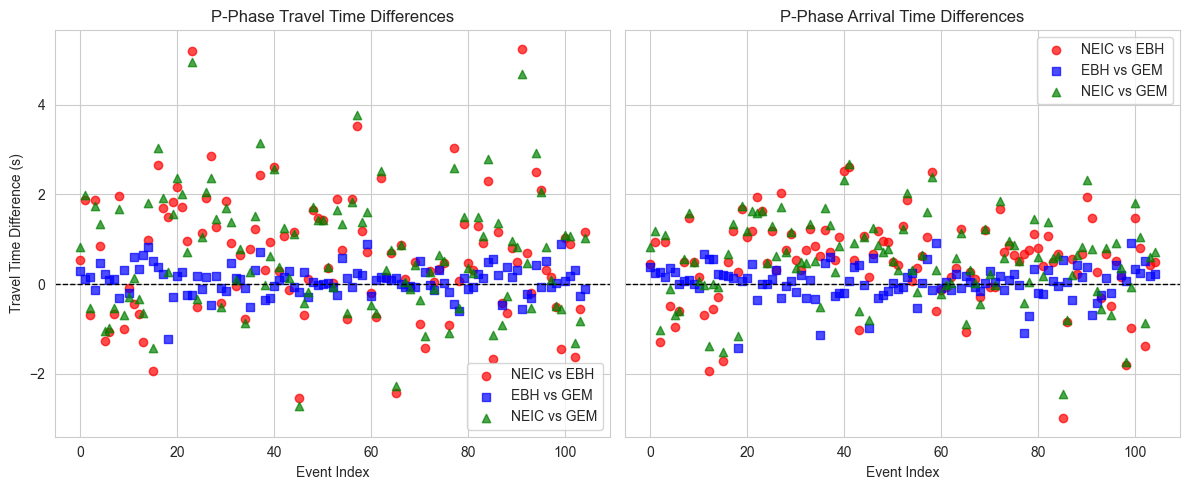

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure style
sns.set_style("whitegrid")

# Filter data for P-phase
p_phase_df = final_merged

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

### Travel Time Differences (Left)
axes[0].scatter(p_phase_df.index, p_phase_df['travel_time_diff_neic_ebh'], marker='o', color='r', alpha=0.7, label='NEIC vs EBH')
axes[0].scatter(p_phase_df.index, p_phase_df['travel_time_diff_ebh_gem'], marker='s', color='b', alpha=0.7, label='EBH vs GEM')
axes[0].scatter(p_phase_df.index, p_phase_df['travel_time_diff_neic_gem'], marker='^', color='g', alpha=0.7, label='NEIC vs GEM')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_title(f"{phase}-Phase Travel Time Differences")
axes[0].set_xlabel("Event Index")
axes[0].set_ylabel("Travel Time Difference (s)")
axes[0].legend()

### Arrival Time Differences (Right)
axes[1].scatter(p_phase_df.index, p_phase_df['arrival_time_diff_neic_ebh'], marker='o', color='r', alpha=0.7, label='NEIC vs EBH')
axes[1].scatter(p_phase_df.index, p_phase_df['arrival_time_diff_ebh_gem'], marker='s', color='b', alpha=0.7, label='EBH vs GEM')
axes[1].scatter(p_phase_df.index, p_phase_df['arrival_time_diff_neic_gem'], marker='^', color='g', alpha=0.7, label='NEIC vs GEM')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title(f"{phase}-Phase Arrival Time Differences")
axes[1].set_xlabel("Event Index")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()